# **1. 데이터 차원**
- 데이터 자체는 충분함
- 불균형 데이터 -> Data Augmentation
- 데이터 범위(scale) 조정: 정규화/규제화/표준화

# **2. 알고리즘 차원**
- 학습률(learning rate)
    - Learning rate Scheduler 활용
- 활성화 함수/손실함수
    - 활성화 함수: softmax
    - 손실 함수: CrossEntropyLoss
- 배치/ Epoch
    - batch size: 128
    - Epoch: 100
    - EarlyStopping 적용
      - 사용자 정의 모듈
      - https://github.com/Bjarten/early-stopping-pytorch

# **3. 하드웨어 차원**
- gpu 활용

In [1]:
### 필요한 라이브러리 준비

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import copy
import argparse

from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from ipywidgets import interact
from module.pytorchtools import EarlyStopping # 사용자 정의 모듈
                                              # 외부 py파일을 모듈로 import하여 EarlyStopping 함수 사용

In [2]:
### gpu 장치 확인
print(torch.__version__) 
print(torch.cuda.get_device_name(0))

1.12.1+cu116
NVIDIA GeForce GTX 1660 SUPER


### **DataLoader**

In [3]:
train_data_dir = './DataSet/archive/train/'
train_data_df = pd.read_csv(os.path.join(train_data_dir,'train.csv'))

# 분류에 사용할 class 정의(7개의 감정들)
feelings_list = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [4]:
IMAGE_SIZE = 48

### 이미지 파일 경로를 리스트 형태로 저장하기 위한 함수
def list_image_file(data_dir,sub_dir):
    image_files = []
    
    images_dir = os.path.join(data_dir,sub_dir)
    for file_path in os.listdir(images_dir):
        image_files.append(os.path.join(sub_dir,file_path))
    return image_files

In [5]:
### 학습 데이터셋 클래스

class Feeling_dataset(Dataset):
    ### 생성자
    def __init__(self,data_dir,transform = None):
        self.data_dir = data_dir # 데이터가 저장된 상위 directory
        angry_imgs = list_image_file(data_dir,'angry')
        disgust_imgs = list_image_file(data_dir,'disgust')
        fear_imgs = list_image_file(data_dir,'fear')
        happy_imgs = list_image_file(data_dir,'happy')
        neutral_imgs = list_image_file(data_dir,'neutral')
        sad_imgs = list_image_file(data_dir,'sad')
        surprise_imgs = list_image_file(data_dir,'surprise')
        
        # 모든 사진들의 경로를 하나의 리스트에 저장
        self.files_path = angry_imgs + disgust_imgs + fear_imgs + happy_imgs + neutral_imgs + sad_imgs + surprise_imgs
        self.transform = transform
    
    ### 데이터 개수 확인
    def __len__(self):
        return len(self.files_path) # 전체 데이터 개수
    
    ### getitem
    def __getitem__(self,index):
        # image(feature data)
        image_file = os.path.join(self.data_dir,self.files_path[index])
        image = cv2.imread(image_file)
        image = cv2.resize(image,dsize = (IMAGE_SIZE,IMAGE_SIZE),interpolation = cv2.INTER_LINEAR)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        
        # feeling(target data)
        target = feelings_list.index(self.files_path[index].split(os.sep)[0])
        
        if self.transform:
            image = self.transform(image) # feature data에 대해서만 데이터 변형 수행
            target = torch.Tensor([target]).long()
            
        return {'image':image,'target':target}

In [6]:
### Transformation

# 학습 feature data 변환
train_transformer = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(), # 수평으로 뒤집기
    transforms.RandomVerticalFlip(), # 수직으로 뒤집기
    transforms.ToTensor(), # 텐서로 변환
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]) # 정규화
])

# 검증 feature data 변환
val_transformer = transforms.Compose([
    transforms.ToTensor(), # 텐서로 변환
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]) # 정규화
])

In [7]:
### 데이터로더 구현
def build_dataloader(train_data_dir,val_data_dir):
    dataloaders = {}
    train_dset = Feeling_dataset(train_data_dir,train_transformer)
    dataloaders['train'] = DataLoader(train_dset,batch_size = 128,shuffle = True,drop_last = True)
    
    val_dset = Feeling_dataset(val_data_dir,val_transformer)
    dataloaders['val'] = DataLoader(val_dset,batch_size = 128,shuffle = False,drop_last = False)
    
    return dataloaders

In [8]:
train_data_dir = './DataSet/archive/train/'
val_data_dir = train_data_dir = './DataSet/archive/valid/'
dataloaders = build_dataloader(train_data_dir,val_data_dir)

### **Modeling**

In [9]:
from torchsummary import summary

In [10]:
### 모델 생성 함수
# 기존의 ResNet50 모델 호출 -> head 부분 수정
def build_resnet50_based_model():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    model = models.resnet50(pretrained = True) # 이미 학습된 resnet50 모델 불러오기
    
    # 일반 NN layer(FC layer)
    model.avgpool = nn.AdaptiveAvgPool2d(output_size = (1,1))
    model.fc = nn.Linear(2048,7) # 7개의 감정으로 분류
    
    return model.to(device)

### **Estimation**

In [11]:
### 모델 검증을 위한 accuracy

@torch.no_grad() 
def get_accuracy(image,target,model):
    batch_size = image.shape[0] 
    prediction = model(image) # 예측 
    _,pred_label = torch.max(prediction,dim = 1) # 예측이 어느 클래스에 속하는지 확률이 가장 높은 1개 선택
    is_correct = (pred_label == target)
    
    return is_correct.cpu().numpy().sum() / batch_size

### **Training**

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Epoch을 1번 수행
def train_one_epoch(dataloaders,model,optimizer,loss_func,device):
    losses = {} # loss값 저장
    accuracies = {} # 정확도 값 저장
    
    for tv in ['train','val']:
        ### loss, accuracy를 계속 갱신
        running_loss = 0.0
        running_correct = 0
        
        if tv == 'train': # 학습
            model.train()
        else: # 검증
            model.eval()
        
        for index,batch in enumerate(dataloaders[tv]):
            image = batch['image'].to(device) # feature data(이미지)
            target = batch['target'].squeeze(dim = 1).to(device) # label data(감정), 1차원으로 차원 축소 진행
            
            ### 역전파 적용
            with torch.set_grad_enabled(tv == 'train'): 
                prediction = model(image) # label 예측
                loss = loss_func(prediction,target) # loss값 계산
                
                if tv == 'train':
                    optimizer.zero_grad() # 한 번의 학습 완료 -> gradient를 0으로 초기화
                    loss.backward() # 역전파
                    optimizer.step() # 가중치 업데이트
                    
            running_loss += loss.item()
            running_correct += get_accuracy(image,target,model)
            
            if tv == 'train':
                if index % 30 == 0:
                    print(f"{index}/{len(dataloaders['train'])} - Running loss: {loss.item()}")
        losses[tv] = running_loss / len(dataloaders[tv])
        accuracies[tv] = running_correct / len(dataloaders[tv])
    return losses, accuracies

In [13]:
### 학습이 잘 된 모델 저장
def save_best_model(model_state,model_name,save_dir = './best_model'):
    os.makedirs(save_dir,exist_ok = True) # 경로 존재 시 덮어쓰기, 없는 경우 새로 생성
    torch.save(model_state,os.path.join(save_dir,model_name)) # 모델 저장

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### 경로 설정
train_data_dir = './DataSet/archive/train/'
val_data_dir = './DataSet/archive/valid/'

### 필요한 요소들 준비
dataloaders = build_dataloader(train_data_dir,val_data_dir)
model = build_resnet50_based_model()
loss_func = nn.CrossEntropyLoss(reduction = 'mean')
optimizer = torch.optim.Adam(model.parameters(),lr = 1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', patience = 3, factor = 0.1,
                                                       min_lr = 1e-13,verbose = True)  # lr scheduling
early_stopping = EarlyStopping(patience = 20, verbose = False) # 조기 종료(사용자 정의 모듈)

c:\users\bin\appdata\local\programs\python\python38\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\users\bin\appdata\local\programs\python\python38\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
num_epochs = 100

best_acc = 0.0
train_loss,train_accuracy = [],[]
val_loss,val_accuracy = [],[]

for epoch in range(num_epochs):
    ### 1 Epoch 수행
    losses, accuracies = train_one_epoch(dataloaders, model, optimizer, loss_func, device)
    
    ### LR Scheduling
    scheduler.step(losses['val']) # 1 Epoch 수행 후 learning rate 조정
    # EarlyStopping
    early_stopping(losses['val'], model) # 현재 과적합 상황 추적
    if early_stopping.early_stop: # 조건 만족 시 조기 종료
        break
        
    train_loss.append(losses['train'])
    val_loss.append(losses['val'])
    train_accuracy.append(accuracies['train'])
    val_accuracy.append(accuracies['val'])
    
    print(f"{epoch+1}/{num_epochs}-Train Loss:{losses['train']}, Val Loss:{losses['val']}")
    print(f"{epoch+1}/{num_epochs}-Train Acc:{accuracies['train']}, Val Acc:{accuracies['val']}")
    
    # deepcopy: 배열의 내부 객체까지 복사를 해서 사용
    # copy: 배열의 내부 객체까지 깊은 복사를 해주지 않음
    if (epoch > 3) and (accuracies['val'] > best_acc):
        best_acc = accuracies['val']
        best_model = copy.deepcopy(model.state_dict()) 
        save_best_model(best_model, f'model_{epoch+1:02d}.pth')

print(f'Best Accuracy: {best_acc}')

0/227 - Running loss: 2.043168544769287
30/227 - Running loss: 1.491761565208435
60/227 - Running loss: 1.5623548030853271
90/227 - Running loss: 1.45649254322052
120/227 - Running loss: 1.414207100868225
150/227 - Running loss: 1.61042320728302
180/227 - Running loss: 1.2214220762252808
210/227 - Running loss: 1.239039659500122
1/100-Train Loss:1.4652372141766654, Val Loss:1.2778725130804653
1/100-Train Acc:0.5103593061674009, Val Acc:0.5060500073056692
0/227 - Running loss: 1.283246397972107
30/227 - Running loss: 1.228438377380371
60/227 - Running loss: 1.3754911422729492
90/227 - Running loss: 1.079135775566101
120/227 - Running loss: 1.2779141664505005
150/227 - Running loss: 1.310020923614502
180/227 - Running loss: 1.0836060047149658
210/227 - Running loss: 1.37679123878479
2/100-Train Loss:1.2514789298767561, Val Loss:1.2603506363671402
2/100-Train Acc:0.5700027533039648, Val Acc:0.5151592635885447
0/227 - Running loss: 1.0240668058395386
30/227 - Running loss: 1.14577758312225

0/227 - Running loss: 0.5452835559844971
30/227 - Running loss: 0.5544405579566956
60/227 - Running loss: 0.5825753211975098
90/227 - Running loss: 0.6567469835281372
120/227 - Running loss: 0.47159114480018616
150/227 - Running loss: 0.5118648409843445
180/227 - Running loss: 0.74812912940979
210/227 - Running loss: 0.42214828729629517
EarlyStopping counter: 1 out of 20
18/100-Train Loss:0.5283991074772133, Val Loss:1.0332197526405598
18/100-Train Acc:0.8185228524229075, Val Acc:0.6447937974868497
0/227 - Running loss: 0.47107231616973877
30/227 - Running loss: 0.4821832776069641
60/227 - Running loss: 0.44248178601264954
90/227 - Running loss: 0.5718349814414978
120/227 - Running loss: 0.5069364905357361
150/227 - Running loss: 0.43871375918388367
180/227 - Running loss: 0.42226386070251465
210/227 - Running loss: 0.3978651463985443
EarlyStopping counter: 2 out of 20
19/100-Train Loss:0.48870478170033593, Val Loss:1.0606252787442043
19/100-Train Acc:0.8378992290748899, Val Acc:0.6464

30/227 - Running loss: 0.2714554965496063
60/227 - Running loss: 0.4580584168434143
90/227 - Running loss: 0.35820242762565613
120/227 - Running loss: 0.2932683527469635
150/227 - Running loss: 0.4718988537788391
180/227 - Running loss: 0.43145662546157837
210/227 - Running loss: 0.4231405258178711
EarlyStopping counter: 17 out of 20
34/100-Train Loss:0.3548738673526285, Val Loss:1.1345974689927594
34/100-Train Acc:0.8832599118942731, Val Acc:0.6466339129164231
0/227 - Running loss: 0.4033602178096771
30/227 - Running loss: 0.33499130606651306
60/227 - Running loss: 0.3197225332260132
90/227 - Running loss: 0.28623294830322266
120/227 - Running loss: 0.3763267993927002
150/227 - Running loss: 0.35065895318984985
180/227 - Running loss: 0.27204078435897827
210/227 - Running loss: 0.5014086961746216
EarlyStopping counter: 18 out of 20
35/100-Train Loss:0.34883986426607627, Val Loss:1.1391837637999962
35/100-Train Acc:0.8821585903083701, Val Acc:0.6493735388661601
0/227 - Running loss: 0.

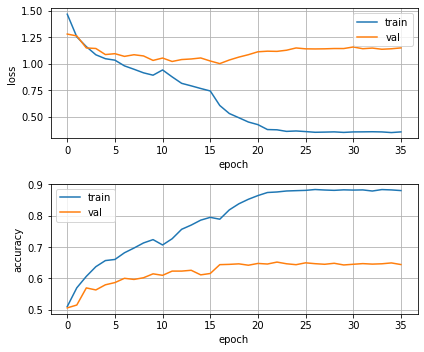

In [16]:
### Loss, Accuracy 시각화

plt.figure(figsize = (6,5))

# Loss
plt.subplot(211)
plt.plot(train_loss,label = "train")
plt.plot(val_loss,label = "val")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid("on")
plt.legend()

# Accuracy
plt.subplot(212)
plt.plot(train_accuracy,label = "train")
plt.plot(val_accuracy,label = "val")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.grid("on")
plt.legend()

plt.tight_layout()